In [8]:
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from glob import glob
import pandas as pd
from scipy.integrate import simps

In [2]:
mpl.rcParams['figure.dpi'] = 500
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.size'] = 28
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['axes.linewidth'] = 1

In [3]:
columns = "depth	H  1 4340.94A	H  1 4861.36A	H  1 6562.85A	Ca B 5875.64A	N  2 6583.45A	O  1 6300.30A	O  2 3726.03A	O  2 3728.81A	O  3 5006.84A	BLND 4363.00A	S  2 6716.44A	S  2 6730.82A	Cl 3 5517.71A	Cl 3 5537.87A	O  1 63.1679m	O  1 145.495m	C  2 157.636m	He 2 4686.01A"

In [4]:
def plot_O32_O3Hb_grid(ax, grids_path, hden=-1, SED_type=26, linestyle='solid'):
    logUs = []
    metals = []
    O32s = []
    O3Hbs = []
    #filename = f"my_model_grid_{ion_param}_{metallicity}_{hden}_{SED_type}.in"
    for emisfile in glob(grids_path+f'*{hden}_{SED_type}.emis'):
        logU, metal, hden, SED = emisfile.split('/')[-1].split('.emis')[0].split('my_model_grid_')[-1].split('_')
        # Define constants
        kpc_to_cm = 3.0857e21  # Conversion factor from kpc to cm
        r_0 = 10 * kpc_to_cm   # 10 kpc in cm
        # Load the .emis file
        data = pd.read_csv(emisfile, delim_whitespace=True, names=columns.split('\t'), index_col=False, header=0)
        # Extract the relevant columns
        depth = data['depth'].values  # Depth in cm
        emissivity_OII = data[['O  2 3726.03A', 'O  2 3728.81A']].sum(axis=1).values  # Replace '[OII]' with the actual column name for [OII] doublets
        emissivity_OIII = data['O  3 5006.84A'].values  # Replace '[OIII]5007' with the actual column name for [OIII] 5007
        emissivity_Hbeta = data['H  1 4861.36A'].values  # Replace 'Hbeta' with the actual column name for Hbeta
        # Calculate the radius r = 10 kpc + depth
        r = r_0 + depth
        # Integrate the emissivities in spherical coordinates
        try:
            flux_OII = simps(4 * np.pi * r**2 * emissivity_OII, r)
            flux_OIII = simps(4 * np.pi * r**2 * emissivity_OIII, r)
            flux_Hbeta = simps(4 * np.pi * r**2 * emissivity_Hbeta, r)
            O32s.append(flux_OIII/flux_OII)
            O3Hbs.append(flux_OIII/flux_Hbeta)
            logUs.append(float(logU))
            metals.append(float(metal))
        except ValueError:
            print(f"----- No lines for {emisfile} -----!")
            continue
    logUlist = np.asarray(logUs)
    metallist = np.asarray(metals)
    O32list = np.asarray(O32s)
    O3Hblist = np.asarray(O3Hbs)
    argsorts = logUlist.argsort()
    metallist = metallist[argsorts]
    O32list = O32list[argsorts]
    O3Hblist = O3Hblist[argsorts]
    #sort the data name by the order of logU
    logUlist.sort() #sort logU too
    ####### plot grid lines #######
    #SED_type = SED_type.split('.')[0]
    logU_cmap = mpl.colormaps['Reds']
    logU_colors = logU_cmap(np.linspace(0.3, 1, len(np.unique(logUlist))))
    metal_cmap = mpl.colormaps['Blues']
    metal_colors = metal_cmap(np.linspace(0.3, 1, len(np.unique(metallist))))[np.unique(metallist).argsort()]
    for i, logU in enumerate(np.unique(logUlist)):
        O32 = O32list[logUlist==logU]
        O3Hb = O3Hblist[logUlist==logU]
        O32 = O32[O3Hb.argsort()]
        O3Hb.sort()
        logU_color = logU_colors[i]
        ax.plot(np.log10(O32), np.log10(O3Hb), color=logU_color , linestyle=linestyle, label='logU='+str(logU))
    for i, metal in enumerate(np.unique(metallist)):
        O32 = O32list[metallist==metal]
        O3Hb = O3Hblist[metallist==metal]
        O3Hb = O3Hb[O32.argsort()]
        O32.sort()
        metal_color = metal_colors[i]
        ax.plot(np.log10(O32), np.log10(O3Hb), color=metal_color , linestyle=linestyle, label='Z='+str(metal))        
    ax.errorbar(x=-0.12, y=0.23, xerr=0.05, fmt='o', color='red', markersize=8, capsize=3, label='This work') #errorbar 0.05
    ax.annotate('', xy=(-0.12, 0.5), xytext=(-0.12, 0.23),
            arrowprops=dict(arrowstyle="->", color='red', lw=2))
    ax.text(-2, -2.4, 'Young Stars (dashed)')
    ax.text(-1.5, 0.2, 'AGN (solid)')
    ax.set_xlabel(r'log([OIII]$\lambda$5007/[OII]$\lambda\lambda$3726,3729)')
    ax.set_ylabel(r'log([OIII]$\lambda$5007/H$\beta$)')

/tmp/ipykernel_933661/513479462.py:13: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  data = pd.read_csv(emisfile, delim_whitespace=True, names=columns.split('\t'), index_col=False, header=0)
/tmp/ipykernel_933661/513479462.py:13: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  data = pd.read_csv(emisfile, delim_whitespace=True, names=columns.split('\t'), index_col=False, header=0)
/tmp/ipykernel_933661/513479462.py:13: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  data = pd.read_csv(emisfile, delim_whitespace=True, names=columns.split('\t'), index_col=False, header=0)
/tmp/ipykernel_933661/513479462.py:13: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  data = pd.read_csv(emisfil

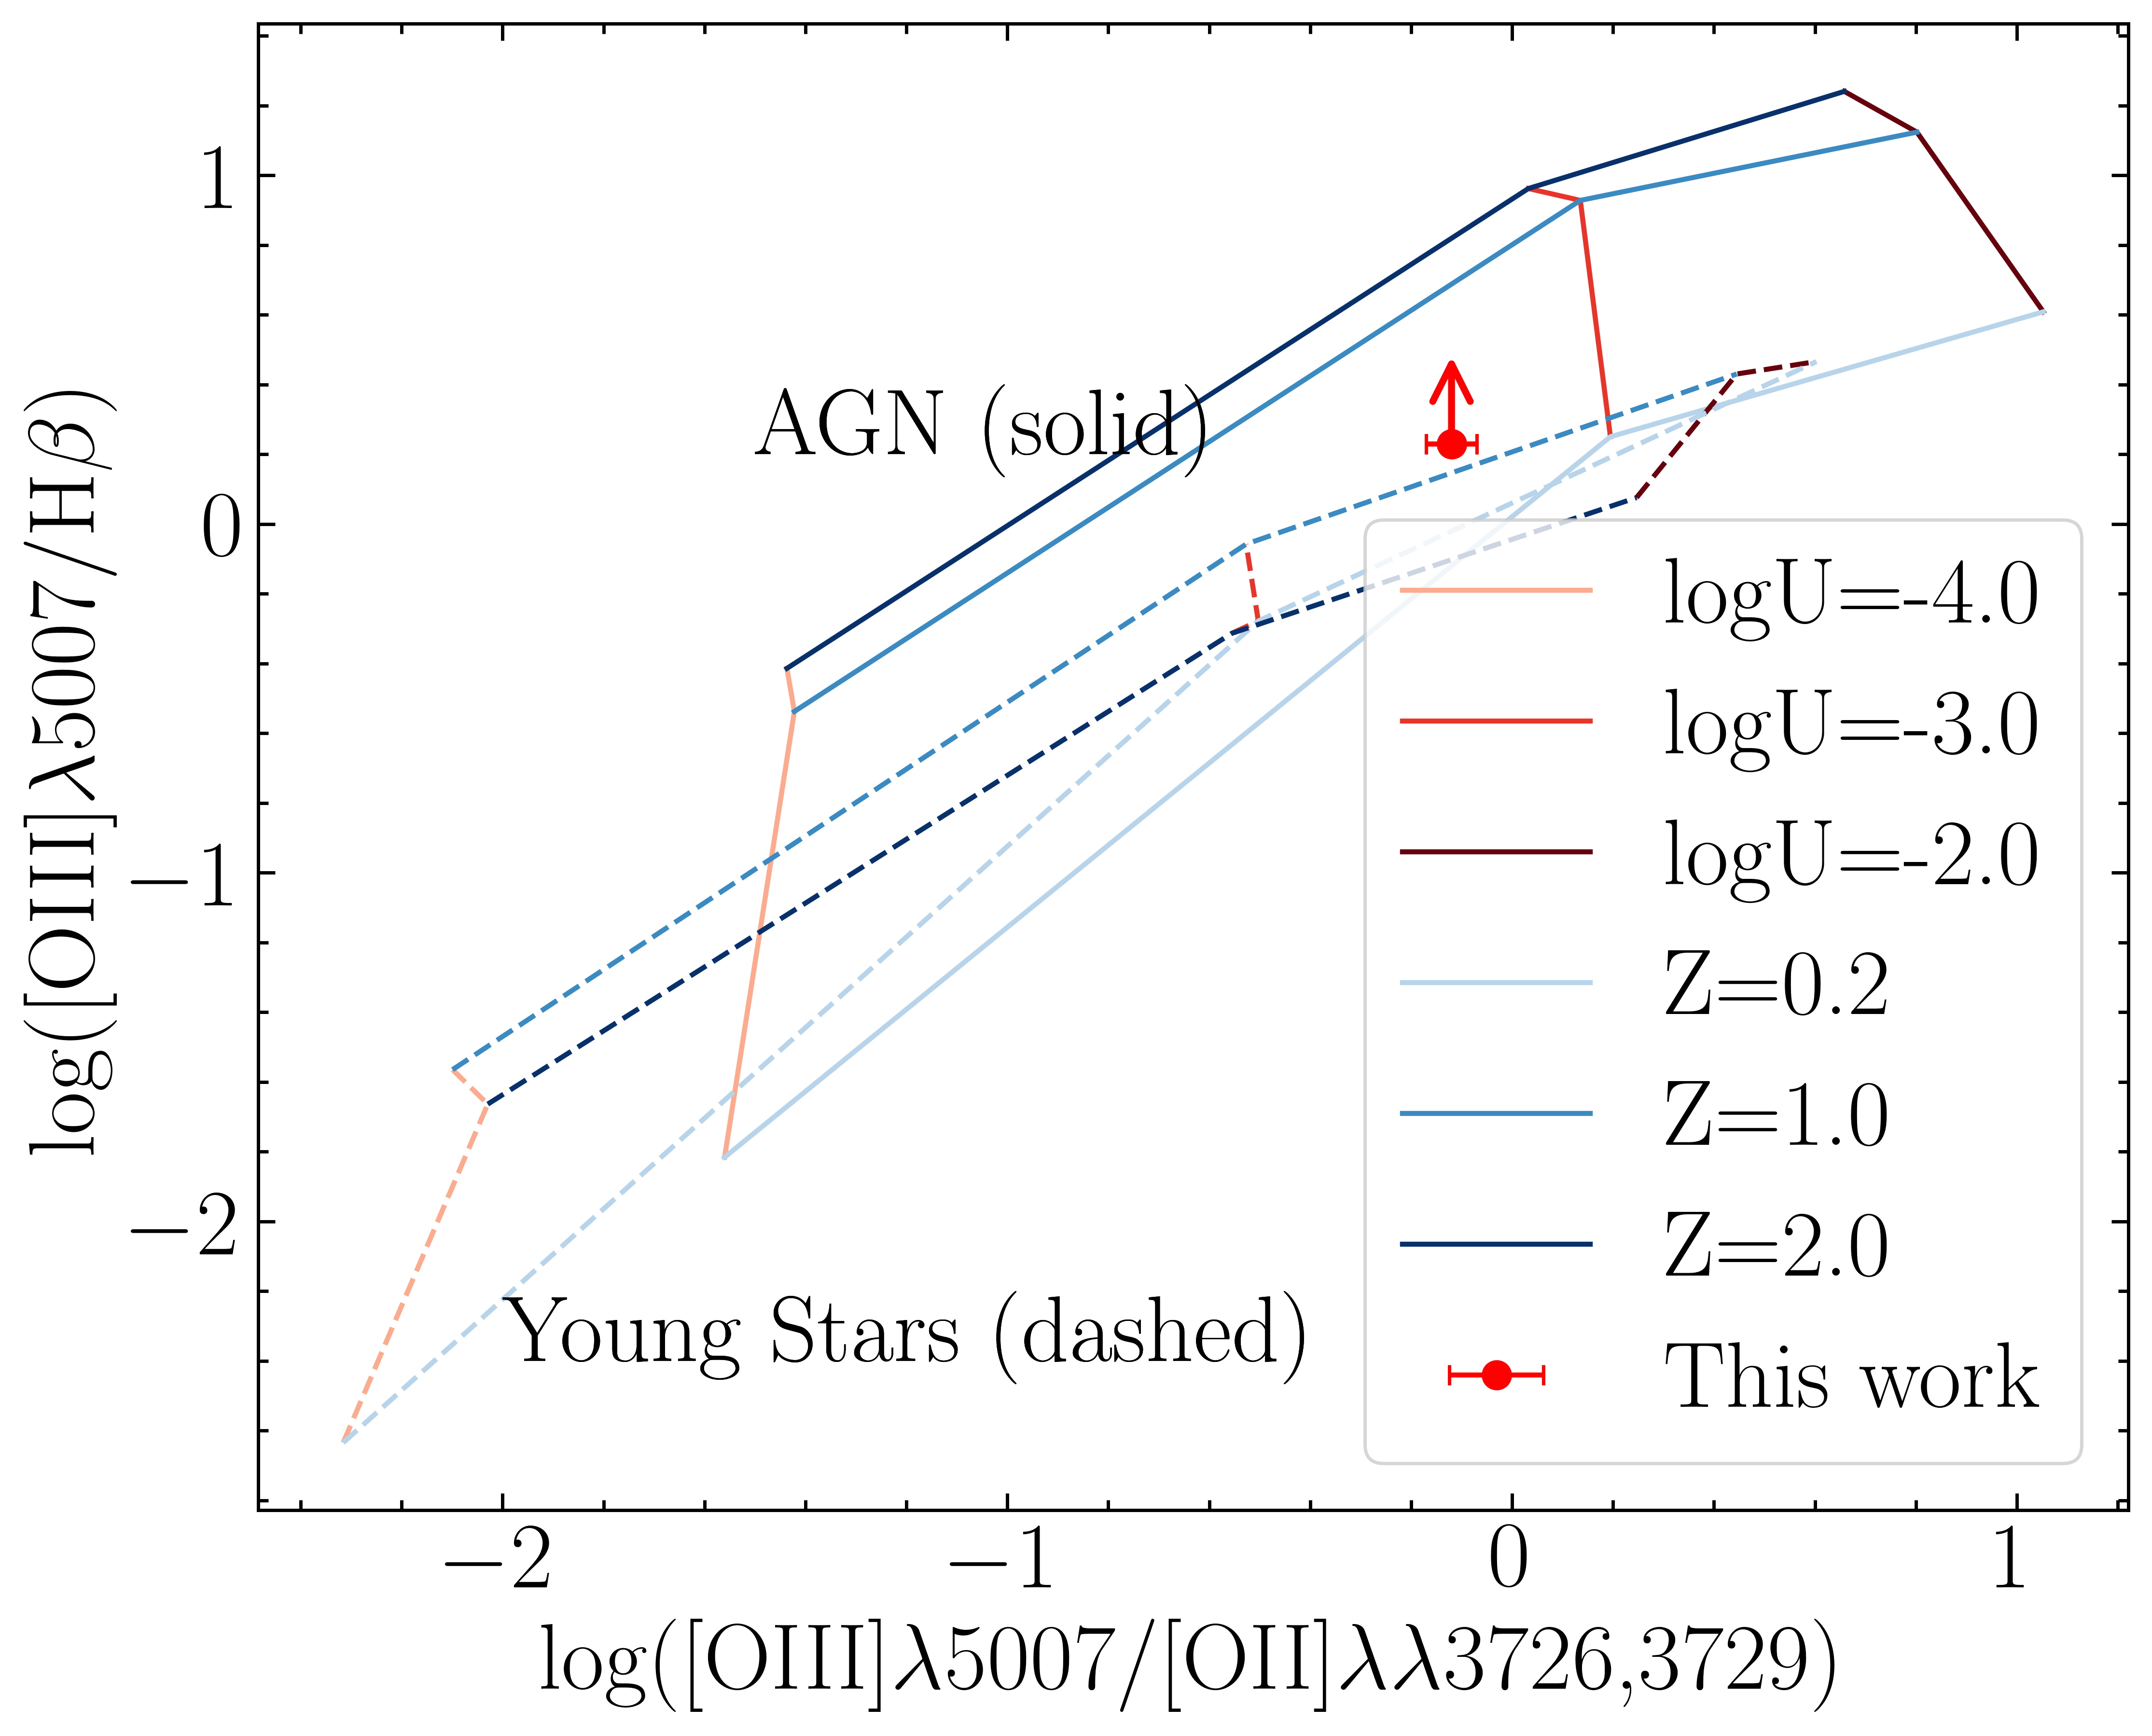

In [13]:
fig, ax = plt.subplots(figsize=(10,8))
plot_O32_O3Hb_grid(ax, grids_path='./data/cloudy_model/AGNgrids_7_5/', hden=0, SED_type=34, linestyle='solid')
plt.legend()
plot_O32_O3Hb_grid(ax, grids_path='./data/cloudy_model/stargrids_test/', hden=0, SED_type='stellar', linestyle='dashed')
plt.savefig('line_grids_stellar_AGN.pdf')
plt.show()

/tmp/ipykernel_933661/513479462.py:13: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  data = pd.read_csv(emisfile, delim_whitespace=True, names=columns.split('\t'), index_col=False, header=0)
/tmp/ipykernel_933661/513479462.py:13: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  data = pd.read_csv(emisfile, delim_whitespace=True, names=columns.split('\t'), index_col=False, header=0)
/tmp/ipykernel_933661/513479462.py:13: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  data = pd.read_csv(emisfile, delim_whitespace=True, names=columns.split('\t'), index_col=False, header=0)
/tmp/ipykernel_933661/513479462.py:13: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  data = pd.read_csv(emisfil

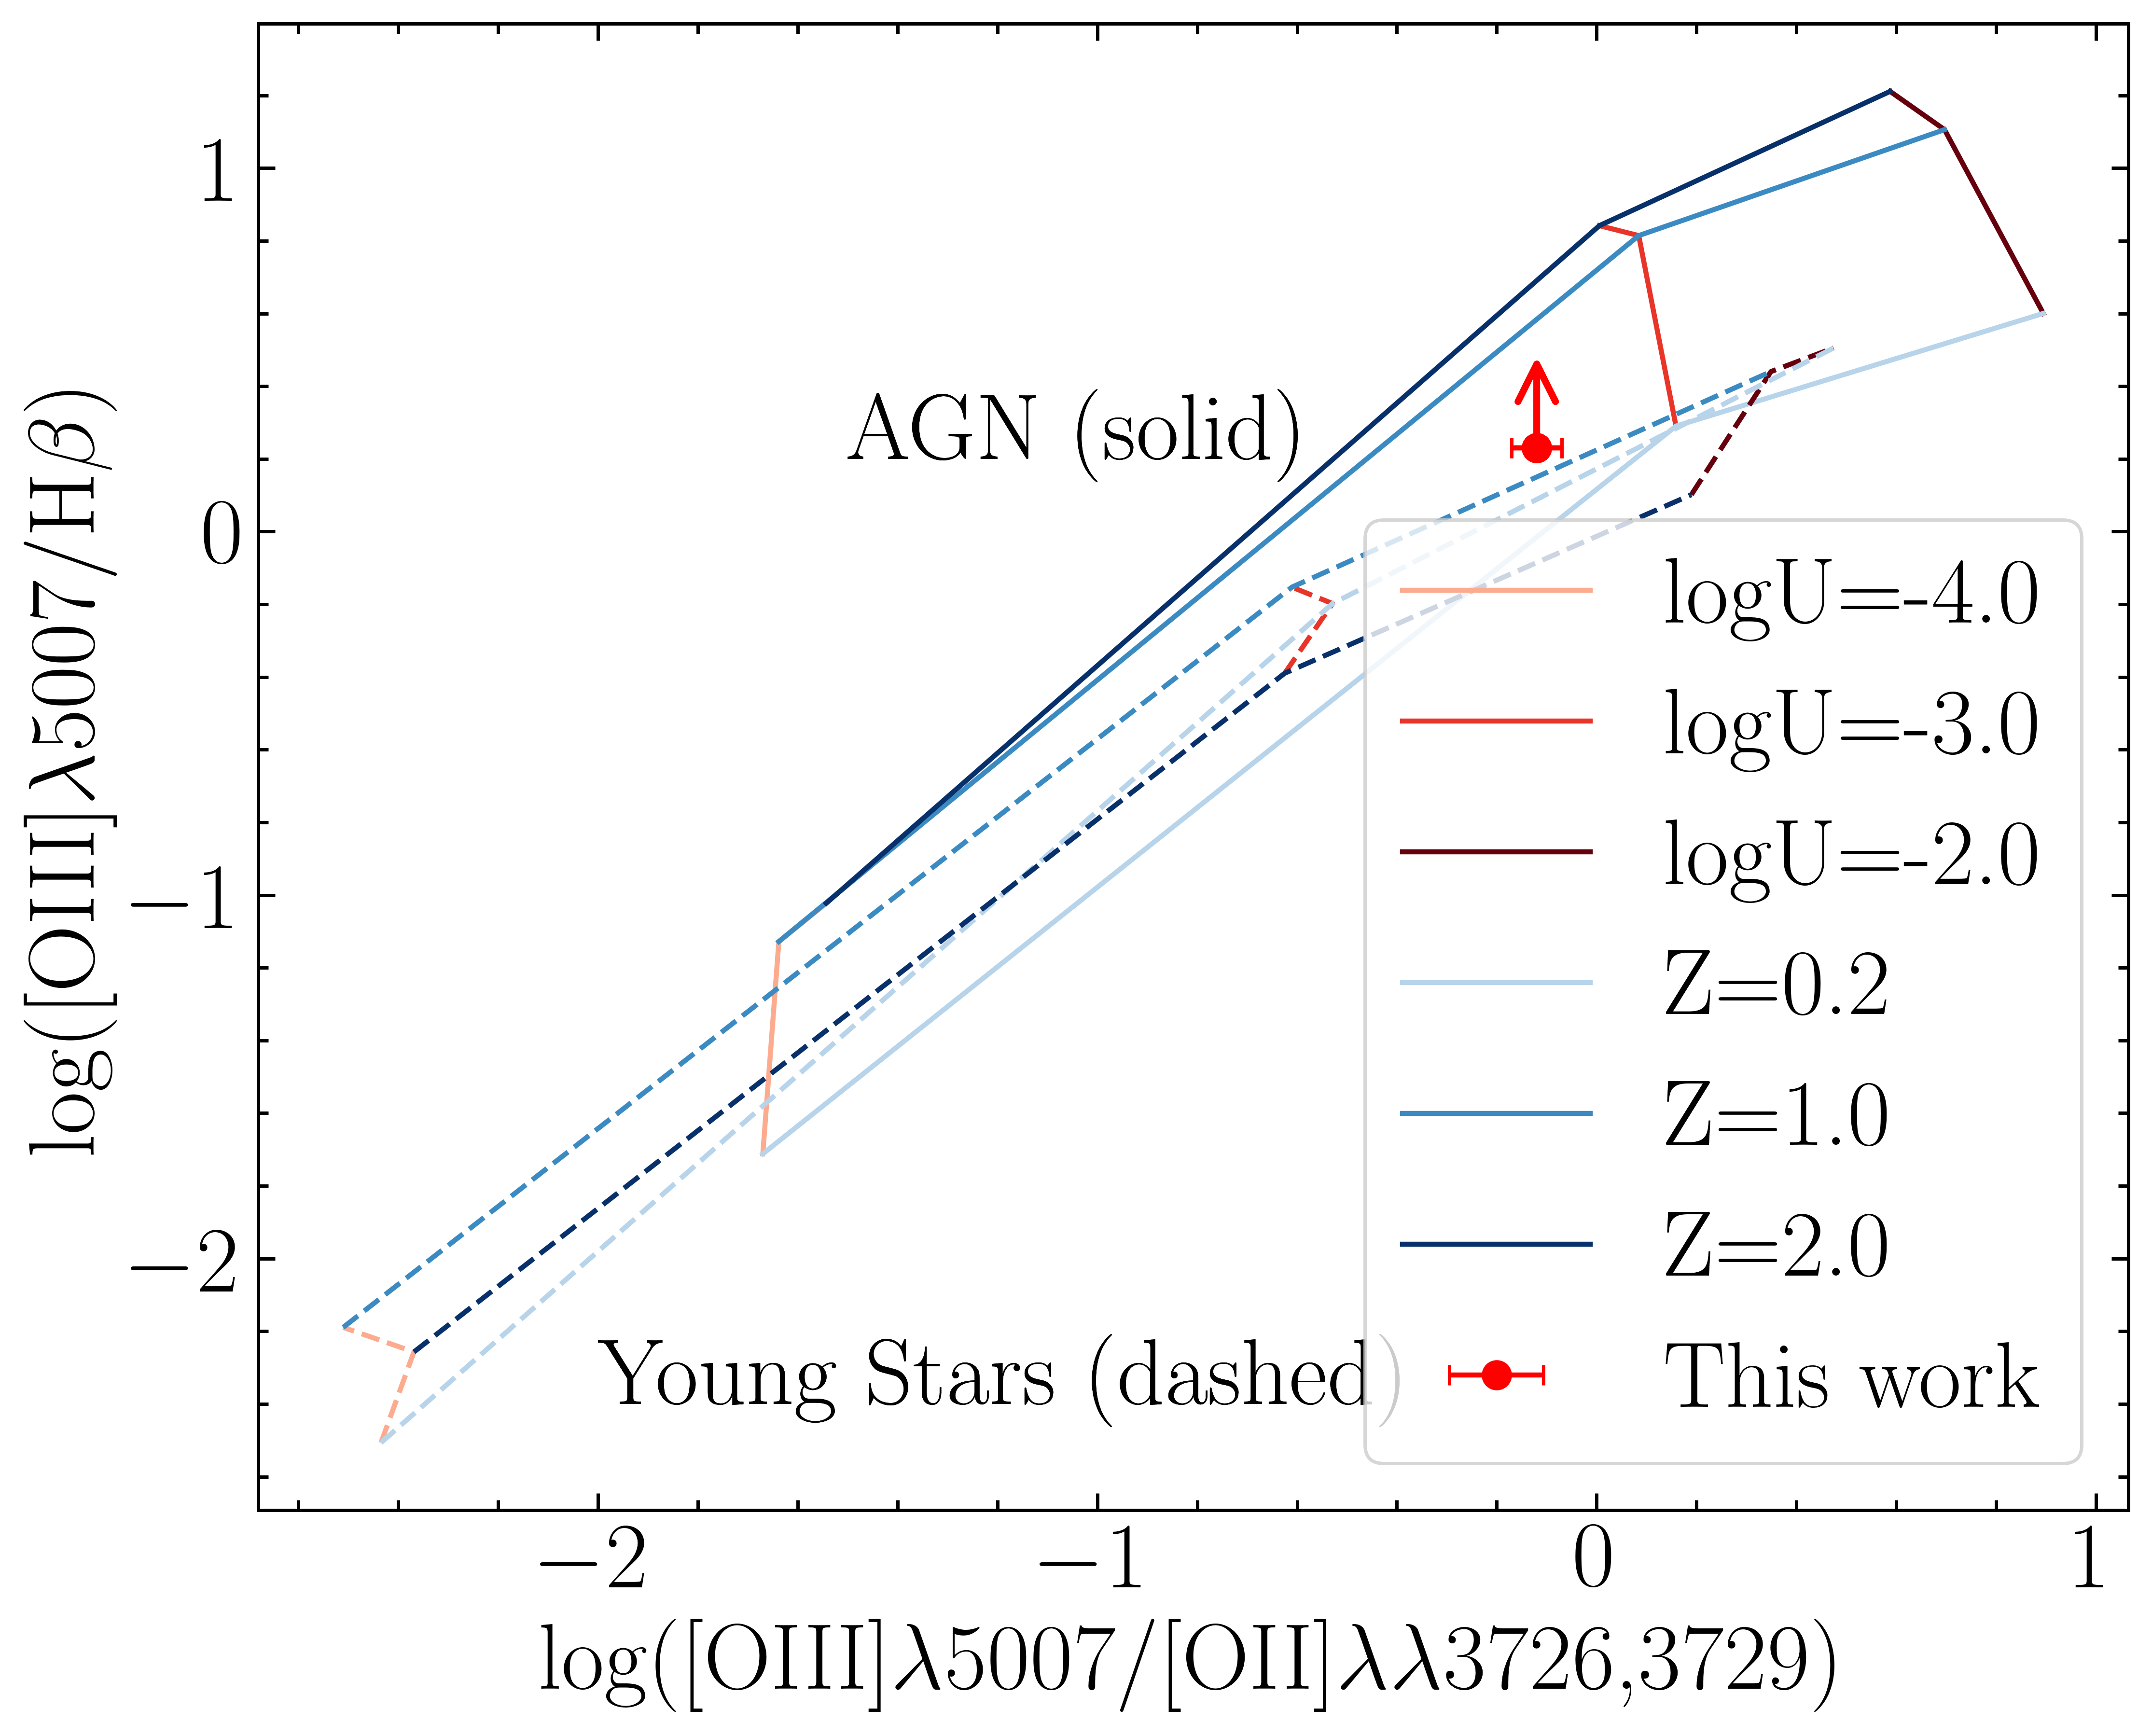

In [14]:
fig, ax = plt.subplots(figsize=(10,8))
plot_O32_O3Hb_grid(ax, grids_path='./data/cloudy_model/AGNgrids_7_5/', hden=-1, SED_type=34, linestyle='solid')
plt.legend()
plot_O32_O3Hb_grid(ax, grids_path='./data/cloudy_model/stargrids_test/', hden=-1, SED_type='stellar', linestyle='dashed')
plt.show()